## 1. 데이터 불러오기

In [4]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [5]:
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [6]:
TRAIN_CSV = r"train.csv" # 각자 컴퓨터 파일 경로로 바꾸셔야할 듯
TEST_CSV  = r"test.csv"

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

In [7]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

"""
[train.csv]                                         [test.csv]
ID : 샘플별 고유 ID                                 ID : 샘플별 고유 ID
gender : 성별                                       gender : 성별
age : 연령                                          age : 연령
height : 키(cm)                                     height : 키(cm)
weight : 몸무게(kg)                                 weight : 몸무게(kg)
cholesterol : 콜레스테롤 수치                       cholesterol : 콜레스테롤 수치
systolic_blood_pressure : 수축기 혈압               systolic_blood_pressure : 수축기 혈압
diastolic_blood_pressure : 이완기 혈압              diastolic_blood_pressure : 이완기 혈압
glucose : 혈당 수치(mg/dL)                          glucose : 혈당 수치(mg/dL)
bone_density : 골밀도(g/cm²)                        bone_density : 골밀도(g/cm²)
activity : 생활시 운동 강도                         activity : 생활시 운동 강도
smoke_status : 흡연 상태                            smoke_status : 흡연 상태
medical_history : 만성질환                          medical_history : 만성질환
family_medical_history : 가족력                     family_medical_history : 가족력
sleep_pattern : 수면패턴                            sleep_pattern : 수면패턴
edu_level : 학력                                    edu_level : 학력
mean_working : 1주일당 평균 근로 시간               mean_working : 1주일당 평균 근로 시간
stress_score : (TARGET) 스트레스 점수                    
"""

display(train.shape)

(3000, 18)

## 2. 데이터 전처리

In [8]:
# 카테고리형 변수의 결측값을 최빈값으로 대체
# 최빈값 -> 가장 많이 관측된 값
categorical_na_cols = train.select_dtypes(include=['object', 'category']).columns.drop('ID')

for col in categorical_na_cols:
    # # 학습 데이터에서 최빈값 계산
    # most_frequent = train[col].mode()[0]
    # print(f"{col}: {most_frequent}")
    # # 학습 데이터와 테스트 데이터 모두 해당 칼럼의 최빈값으로 대체
    # train[col] = train[col].fillna(most_frequent)
    # test[col] = test[col].fillna(most_frequent)

    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

    print(f"{col}: {train[col].unique()}")

gender: ['F' 'M']
activity: ['moderate' 'light' 'intense']
smoke_status: ['ex-smoker' 'non-smoker' 'current-smoker']
medical_history: ['high blood pressure' 'None' 'diabetes' 'heart disease']
family_medical_history: ['diabetes' 'None' 'high blood pressure' 'heart disease']
sleep_pattern: ['sleep difficulty' 'normal' 'oversleeping']
edu_level: ['bachelors degree' 'graduate degree' 'high school diploma' 'None']


In [9]:
# mean_working에 대해 중앙값 대체
# median_value = train['mean_working'].median()

# mean_working 결측치 -> 0
train['mean_working'] = train['mean_working'].fillna(0)
test['mean_working'] = test['mean_working'].fillna(0)

display(train.columns)

Index(['ID', 'gender', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'smoke_status', 'medical_history',
       'family_medical_history', 'sleep_pattern', 'edu_level', 'mean_working',
       'stress_score'],
      dtype='object')

In [10]:
# One-Hot Encoding 적용 열 - gender, smoke_status, medical_history, family_medical_history
# 원핫 인코딩 => 카테고리끼리 순서 없을때 사용
# smoke_status는 좀 애매하긴 한듯
def one_hot_encoding(df):
    one_hot_encoding_cols = ['gender', 'smoke_status', 'medical_history', 'family_medical_history']
    encoding_df = pd.get_dummies(df, columns=one_hot_encoding_cols)
    return encoding_df

train = one_hot_encoding(train)
test = one_hot_encoding(test)

display(train.columns)
display(train.shape)

Index(['ID', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'sleep_pattern', 'edu_level',
       'mean_working', 'stress_score', 'gender_F', 'gender_M',
       'smoke_status_current-smoker', 'smoke_status_ex-smoker',
       'smoke_status_non-smoker', 'medical_history_None',
       'medical_history_diabetes', 'medical_history_heart disease',
       'medical_history_high blood pressure', 'family_medical_history_None',
       'family_medical_history_diabetes',
       'family_medical_history_heart disease',
       'family_medical_history_high blood pressure'],
      dtype='object')

(3000, 27)

In [11]:
# Label Encoding 적용 열 - activity, sleep_pattern, edu_level
# 라벨 인코딩 => 카테고리끼리 순서 있을때 사용
def label_encoding(df):
    label_encoding_cols = ['activity', 'sleep_pattern', 'edu_level']
    for feature in label_encoding_cols:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

train = label_encoding(train)
test = label_encoding(test)

## 3. 피처 엔지니어링

In [12]:
# BMI => 몸무게[kg] / 키[cm]^2
# 혈압차(맥압) => 수축성 혈압 - 이완성 혈압
def add_features(df):
    df['BMI'] = df['weight'] / ((df['height']/100)**2)
    df['bp_diff'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    return df

train = add_features(train)
test = add_features(test)

In [13]:
display(train['mean_working'].describe())

# working_group 피처 만들기
bins = [3, 8, 9, 16]  # 적절한 경계값 설정
labels = [0, 1, 2]     # 저, 중하, 중상, 고 근무

train['working_group'] = pd.cut(train['mean_working'], bins=bins, labels=labels, include_lowest=True)
test['working_group'] = pd.cut(test['mean_working'], bins=bins, labels=labels, include_lowest=True)

overwork_threshold = train['mean_working'].quantile(0.95)  # 상위 5% 기준값
train['is_overwork'] = (train['mean_working'] >= overwork_threshold).astype(int)
test['is_overwork'] = (test['mean_working'] >= overwork_threshold).astype(int)

display(train['working_group'].value_counts())
display(train['is_overwork'].value_counts())

count    3000.000000
mean        5.718333
std         4.346642
min         0.000000
25%         0.000000
50%         8.000000
75%         9.000000
max        16.000000
Name: mean_working, dtype: float64

working_group
0    888
2    543
1    537
Name: count, dtype: int64

is_overwork
0    2803
1     197
Name: count, dtype: int64

In [14]:
# mean_working & sleep_pattern 피처 엔지니어링

train['work_sleep_imbalance'] = train['mean_working'] / (train['sleep_pattern'] + 1)
test['work_sleep_imbalance'] = test['mean_working'] / (test['sleep_pattern'] + 1)

display(train[['work_sleep_imbalance', 'stress_score']])

for col in train.columns:
    if col not in ['ID', 'stress_score']:
        corr_val = train['stress_score'].corr(train[col])
        print(f"{col} ↔ stress_score 상관계수: {corr_val:.4f}")

work_sleep_imbalance  stress_score
0                      0.0          0.63
1                      0.0          0.83
2                      9.0          0.70
3                      0.0          0.17
4                      0.0          0.36
...                    ...           ...
2995                   0.0          0.02
2996                   9.0          0.16
2997                   9.0          0.16
2998                   0.0          0.18
2999                   0.0          0.04

[3000 rows x 2 columns]

age ↔ stress_score 상관계수: 0.0187
height ↔ stress_score 상관계수: -0.0057
weight ↔ stress_score 상관계수: 0.0113
cholesterol ↔ stress_score 상관계수: 0.0213
systolic_blood_pressure ↔ stress_score 상관계수: 0.0156
diastolic_blood_pressure ↔ stress_score 상관계수: 0.0254
glucose ↔ stress_score 상관계수: -0.0061
bone_density ↔ stress_score 상관계수: -0.0226
activity ↔ stress_score 상관계수: 0.0070
sleep_pattern ↔ stress_score 상관계수: 0.0002
edu_level ↔ stress_score 상관계수: -0.0271
mean_working ↔ stress_score 상관계수: 0.0240
gender_F ↔ stress_score 상관계수: 0.0136
gender_M ↔ stress_score 상관계수: -0.0136
smoke_status_current-smoker ↔ stress_score 상관계수: 0.0261
smoke_status_ex-smoker ↔ stress_score 상관계수: -0.0320
smoke_status_non-smoker ↔ stress_score 상관계수: 0.0087
medical_history_None ↔ stress_score 상관계수: -0.0504
medical_history_diabetes ↔ stress_score 상관계수: 0.0245
medical_history_heart disease ↔ stress_score 상관계수: 0.0000
medical_history_high blood pressure ↔ stress_score 상관계수: 0.0373
family_medical_history_None ↔ stress_score 상관계수: -0.03

## 4. 교차검증

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [16]:
feature_cols = [c for c in train.columns if c not in ['ID','stress_score']] # ID와 stress_score를 제외한 나머지 칼럼 이름만 뽑아서 리스트
x_train = train[feature_cols]
y_train = train['stress_score']

y_binned = pd.qcut(y_train, q= 5, labels = False)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42) # Stratified K-Fold 설정: 5fold, 데이터 분포를 유지하며 섞기

for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y_binned),1): # 각 fold별 학습 & 검증
    X_tr, X_val = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    # tr_idx에는 4개의 fold 인덱스(학습셋) val_idx에는 1개의 fold 인덱스(검증셋)
    # 5번 반복 시 데이터의 모든 부분을 한번씩 검증셋 역할(5Fold 교차검증)
    

In [17]:
# 이 교차검증 셋으로 XGBoost model fit 해주시면 될거 같아요!

## 5. 모델링

In [18]:
x_train = train.drop(['ID', 'stress_score'], axis = 1)
x_val = train['stress_score']
y_train = train['stress_score']

test = test.drop('ID', axis = 1)

In [22]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    # category 타입이면 'None'을 카테고리에 추가 후 fillna
    if str(x_train[col].dtype) == 'category':
        x_train[col] = x_train[col].cat.add_categories(['None']).fillna('None')
        test_x[col] = test_x[col].cat.add_categories(['None']).fillna('None')
    else:
        x_train[col] = x_train[col].fillna('None')
        test_x[col] = test_x[col].fillna('None')
    le = LabelEncoder()
    le.fit(list(x_train[col]) + list(test_x[col]))
    x_train[col] = le.transform(x_train[col])
    test_x[col] = le.transform(test_x[col])

C:\Users\JeongJungu\AppData\Local\Temp\ipykernel_14852\2259154077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].cat.add_categories(['None']).fillna('None')
C:\Users\JeongJungu\AppData\Local\Temp\ipykernel_14852\2259154077.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = le.transform(x_train[col])


In [25]:
# lgbm = LGBMRegressor(random_state = 42)
# lgbm.fit(x_train, y_train)

# pred = lgbm.predict(test)

feature_cols = [c for c in train.columns if c not in ['ID','stress_score']]
x_train = train[feature_cols]
y_train = train['stress_score']
test_x = test[feature_cols]

y_binned = pd.qcut(y_train, q=5, labels=False)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for col in x_train.select_dtypes(include='category').columns:
    x_train[col] = x_train[col].cat.add_categories([-1]).fillna(-1).astype(int)
    test_x[col] = test_x[col].cat.add_categories([-1]).fillna(-1).astype(int)



def objective(trial):
    # LGBM 하이퍼파라미터
    lgbm_params = {
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 100),
        'max_depth': trial.suggest_int('lgbm_max_depth', 3, 10),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 1000),
        'random_state': 42
    }
    # XGB 하이퍼파라미터
    xgb_params = {
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    # RF 하이퍼파라미터
    rf_params = {
        'max_depth': trial.suggest_int('rf_max_depth', 3, 15),
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    # 앙상블 가중치
    w1 = trial.suggest_float('w1', 0, 1)
    w2 = trial.suggest_float('w2', 0, 1)
    w3 = trial.suggest_float('w3', 0, 1)
    if w1 + w2 + w3 == 0:
        return float('inf')

    oof_pred_lgbm = np.zeros(len(x_train))
    oof_pred_xgb = np.zeros(len(x_train))
    oof_pred_rf = np.zeros(len(x_train))

    for tr_idx, val_idx in skf.split(x_train, y_binned):
        X_tr, X_val = x_train.iloc[tr_idx], x_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        lgbm = LGBMRegressor(**lgbm_params)
        xgb = XGBRegressor(**xgb_params)
        rf = RandomForestRegressor(**rf_params)

        lgbm.fit(X_tr, y_tr)
        xgb.fit(X_tr, y_tr)
        rf.fit(X_tr, y_tr)

        oof_pred_lgbm[val_idx] = lgbm.predict(X_val)
        oof_pred_xgb[val_idx] = xgb.predict(X_val)
        oof_pred_rf[val_idx] = rf.predict(X_val)

    ensemble_pred = (w1 * oof_pred_lgbm + w2 * oof_pred_xgb + w3 * oof_pred_rf) / (w1 + w2 + w3)
    score = np.sqrt(mean_squared_error(y_train, ensemble_pred))
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # n_trials는 상황에 따라 조절

print('Best trial:')
print(study.best_trial.params)
print('Best RMSE:', study.best_value)

# 최적 하이퍼파라미터와 가중치로 전체 데이터 재학습 및 test 예측
best_params = study.best_trial.params
lgbm_params = {
    'num_leaves': best_params['lgbm_num_leaves'],
    'max_depth': best_params['lgbm_max_depth'],
    'learning_rate': best_params['lgbm_learning_rate'],
    'n_estimators': best_params['lgbm_n_estimators'],
    'random_state': 42
}
xgb_params = {
    'max_depth': best_params['xgb_max_depth'],
    'learning_rate': best_params['xgb_learning_rate'],
    'n_estimators': best_params['xgb_n_estimators'],
    'subsample': best_params['xgb_subsample'],
    'colsample_bytree': best_params['xgb_colsample_bytree'],
    'random_state': 42
}
rf_params = {
    'max_depth': best_params['rf_max_depth'],
    'n_estimators': best_params['rf_n_estimators'],
    'max_features': best_params['rf_max_features'],
    'random_state': 42
}
w1, w2, w3 = best_params['w1'], best_params['w2'], best_params['w3']

lgbm = LGBMRegressor(**lgbm_params)
xgb = XGBRegressor(**xgb_params)
rf = RandomForestRegressor(**rf_params)
lgbm.fit(x_train, y_train)
xgb.fit(x_train, y_train)
rf.fit(x_train, y_train)

pred_lgbm_test = lgbm.predict(test_x)
pred_xgb_test = xgb.predict(test_x)
pred_rf_test = rf.predict(test_x)
ensemble_pred_test = (w1 * pred_lgbm_test + w2 * pred_xgb_test + w3 * pred_rf_test) / (w1 + w2 + w3)

submission = pd.read_csv('./sample_submission.csv')
submission['stress_score'] = ensemble_pred_test
submission.to_csv('submit.csv', index=False)

C:\Users\JeongJungu\AppData\Local\Temp\ipykernel_14852\937741423.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].cat.add_categories([-1]).fillna(-1).astype(int)
[I 2025-07-22 12:18:57,291] A new study created in memory with name: no-name-af51ddc5-17ea-4cac-8747-39562aa81ef3


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:19:24,742] Trial 0 finished with value: 0.23983993642794285 and parameters: {'lgbm_num_leaves': 55, 'lgbm_max_depth': 10, 'lgbm_learning_rate': 0.09009862830228933, 'lgbm_n_estimators': 355, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.19260985814889603, 'xgb_n_estimators': 689, 'xgb_subsample': 0.8413924361381573, 'xgb_colsample_bytree': 0.746140055754531, 'rf_max_depth': 5, 'rf_n_estimators': 695, 'rf_max_features': None, 'w1': 0.1878637039091916, 'w2': 0.9206598029401907, 'w3': 0.14883717832484544}. Best is trial 0 with value: 0.23983993642794285.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:19:33,654] Trial 1 finished with value: 0.26089161233022123 and parameters: {'lgbm_num_leaves': 65, 'lgbm_max_depth': 6, 'lgbm_learning_rate': 0.07040828430337619, 'lgbm_n_estimators': 269, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.01779021060403265, 'xgb_n_estimators': 630, 'xgb_subsample': 0.6778753967234444, 'xgb_colsample_bytree': 0.9411852457476959, 'rf_max_depth': 6, 'rf_n_estimators': 729, 'rf_max_features': 'log2', 'w1': 0.75962704402462, 'w2': 0.629635434247367, 'w3': 0.7871779539466252}. Best is trial 0 with value: 0.23983993642794285.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:19:54,362] Trial 2 finished with value: 0.239580723835177 and parameters: {'lgbm_num_leaves': 59, 'lgbm_max_depth': 10, 'lgbm_learning_rate': 0.17953467702751796, 'lgbm_n_estimators': 639, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.16855113057688836, 'xgb_n_estimators': 427, 'xgb_subsample': 0.8323168648545871, 'xgb_colsample_bytree': 0.9965993697117048, 'rf_max_depth': 9, 'rf_n_estimators': 276, 'rf_max_features': None, 'w1': 0.9719136686468586, 'w2': 0.2557287683890165, 'w3': 0.45998580956043755}. Best is trial 2 with value: 0.239580723835177.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:19:59,805] Trial 3 finished with value: 0.25363828619143275 and parameters: {'lgbm_num_leaves': 59, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.032963280880166, 'lgbm_n_estimators': 444, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.18967429093973098, 'xgb_n_estimators': 956, 'xgb_subsample': 0.9692961130618306, 'xgb_colsample_bytree': 0.7901665726588002, 'rf_max_depth': 3, 'rf_n_estimators': 311, 'rf_max_features': 'log2', 'w1': 0.7292025327567531, 'w2': 0.44775251776326486, 'w3': 0.9819819539235799}. Best is trial 2 with value: 0.239580723835177.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:20:57,803] Trial 4 finished with value: 0.23917796905709257 and parameters: {'lgbm_num_leaves': 85, 'lgbm_max_depth': 6, 'lgbm_learning_rate': 0.10194294683528114, 'lgbm_n_estimators': 693, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.15862793684623397, 'xgb_n_estimators': 162, 'xgb_subsample': 0.7468049352207919, 'xgb_colsample_bytree': 0.9860416903403155, 'rf_max_depth': 10, 'rf_n_estimators': 830, 'rf_max_features': None, 'w1': 0.5130726430579676, 'w2': 0.47487147204453717, 'w3': 0.08331135567613523}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:21:26,844] Trial 5 finished with value: 0.24856944414988238 and parameters: {'lgbm_num_leaves': 40, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.18688887710711538, 'lgbm_n_estimators': 441, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.095016459227028, 'xgb_n_estimators': 924, 'xgb_subsample': 0.9698268014133997, 'xgb_colsample_bytree': 0.9604708319758186, 'rf_max_depth': 4, 'rf_n_estimators': 874, 'rf_max_features': None, 'w1': 0.21680288361221411, 'w2': 0.5550973606738518, 'w3': 0.8164860064779375}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:21:31,841] Trial 6 finished with value: 0.26509550086540395 and parameters: {'lgbm_num_leaves': 87, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.1563948426121432, 'lgbm_n_estimators': 279, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.1783021104177641, 'xgb_n_estimators': 832, 'xgb_subsample': 0.6678591227970446, 'xgb_colsample_bytree': 0.8472106868859396, 'rf_max_depth': 3, 'rf_n_estimators': 385, 'rf_max_features': 'log2', 'w1': 0.03981848393736098, 'w2': 0.3571777481202155, 'w3': 0.9704638699400033}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:21:42,843] Trial 7 finished with value: 0.24476489399047113 and parameters: {'lgbm_num_leaves': 23, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.07548344071029765, 'lgbm_n_estimators': 634, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.1708422338312189, 'xgb_n_estimators': 564, 'xgb_subsample': 0.8490705189785838, 'xgb_colsample_bytree': 0.8798190480408338, 'rf_max_depth': 5, 'rf_n_estimators': 819, 'rf_max_features': 'sqrt', 'w1': 0.8846281330634308, 'w2': 0.8876444713518928, 'w3': 0.7138002621418622}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:22:14,512] Trial 8 finished with value: 0.25448776916952937 and parameters: {'lgbm_num_leaves': 62, 'lgbm_max_depth': 10, 'lgbm_learning_rate': 0.16043288387905322, 'lgbm_n_estimators': 100, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.04554744803881117, 'xgb_n_estimators': 149, 'xgb_subsample': 0.9845758375335436, 'xgb_colsample_bytree': 0.6880211181345135, 'rf_max_depth': 15, 'rf_n_estimators': 327, 'rf_max_features': None, 'w1': 0.828858787992659, 'w2': 0.9730055160291105, 'w3': 0.10168981939897603}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:22:29,347] Trial 9 finished with value: 0.25003831959097794 and parameters: {'lgbm_num_leaves': 100, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.016472915505383972, 'lgbm_n_estimators': 645, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.07448854121288026, 'xgb_n_estimators': 539, 'xgb_subsample': 0.7937562579879818, 'xgb_colsample_bytree': 0.7479788872189783, 'rf_max_depth': 10, 'rf_n_estimators': 156, 'rf_max_features': None, 'w1': 0.6273699544334755, 'w2': 0.4412598224942902, 'w3': 0.6810583309045118}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:22:50,270] Trial 10 finished with value: 0.25009260088177426 and parameters: {'lgbm_num_leaves': 82, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.12269524846339053, 'lgbm_n_estimators': 942, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.1300108854135025, 'xgb_n_estimators': 131, 'xgb_subsample': 0.6001850488102912, 'xgb_colsample_bytree': 0.6231662596858614, 'rf_max_depth': 13, 'rf_n_estimators': 989, 'rf_max_features': 'sqrt', 'w1': 0.4403383801830584, 'w2': 0.12063528741773921, 'w3': 0.3078939094924632}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:23:22,699] Trial 11 finished with value: 0.24075112112569072 and parameters: {'lgbm_num_leaves': 76, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.11867439040272693, 'lgbm_n_estimators': 830, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.13974538135161957, 'xgb_n_estimators': 324, 'xgb_subsample': 0.7630214361310728, 'xgb_colsample_bytree': 0.9946040655047466, 'rf_max_depth': 9, 'rf_n_estimators': 491, 'rf_max_features': None, 'w1': 0.9952028996509186, 'w2': 0.1853723802365539, 'w3': 0.4502135018878476}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:23:32,778] Trial 12 finished with value: 0.24114229138685403 and parameters: {'lgbm_num_leaves': 42, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.19878206002866045, 'lgbm_n_estimators': 762, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.14556103254052077, 'xgb_n_estimators': 349, 'xgb_subsample': 0.8968028263693595, 'xgb_colsample_bytree': 0.9099230207983816, 'rf_max_depth': 9, 'rf_n_estimators': 118, 'rf_max_features': None, 'w1': 0.4482366490651928, 'w2': 0.2931958156393235, 'w3': 0.34103869408203785}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:24:18,369] Trial 13 finished with value: 0.25880883724152787 and parameters: {'lgbm_num_leaves': 99, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.14443801642129026, 'lgbm_n_estimators': 708, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.15613689401576678, 'xgb_n_estimators': 342, 'xgb_subsample': 0.727355147599464, 'xgb_colsample_bytree': 0.9862397428901897, 'rf_max_depth': 11, 'rf_n_estimators': 581, 'rf_max_features': None, 'w1': 0.5647961750893206, 'w2': 0.02618176409783496, 'w3': 0.048514280534398165}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:24:48,707] Trial 14 finished with value: 0.24304239377761694 and parameters: {'lgbm_num_leaves': 69, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.05569210734855419, 'lgbm_n_estimators': 564, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.1126337661710389, 'xgb_n_estimators': 444, 'xgb_subsample': 0.8559097167249856, 'xgb_colsample_bytree': 0.8450455921389853, 'rf_max_depth': 7, 'rf_n_estimators': 542, 'rf_max_features': None, 'w1': 0.32847682685619917, 'w2': 0.7039095967177191, 'w3': 0.5260366686066926}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:24:54,633] Trial 15 finished with value: 0.24606504518090583 and parameters: {'lgbm_num_leaves': 44, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.105029963454666, 'lgbm_n_estimators': 991, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.1173187444774233, 'xgb_n_estimators': 241, 'xgb_subsample': 0.733462906986251, 'xgb_colsample_bytree': 0.9250423752176529, 'rf_max_depth': 12, 'rf_n_estimators': 220, 'rf_max_features': 'sqrt', 'w1': 0.977363433363916, 'w2': 0.27145304372121704, 'w3': 0.21409257894061542}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:25:53,006] Trial 16 finished with value: 0.24059699485089941 and parameters: {'lgbm_num_leaves': 51, 'lgbm_max_depth': 6, 'lgbm_learning_rate': 0.13401037768850949, 'lgbm_n_estimators': 829, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.16635359330436766, 'xgb_n_estimators': 235, 'xgb_subsample': 0.9051143646513825, 'xgb_colsample_bytree': 0.9973120489233763, 'rf_max_depth': 8, 'rf_n_estimators': 1000, 'rf_max_features': None, 'w1': 0.6163719255799173, 'w2': 0.7658301132724724, 'w3': 0.5212596400945227}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:26:53,447] Trial 17 finished with value: 0.24550975565283367 and parameters: {'lgbm_num_leaves': 89, 'lgbm_max_depth': 4, 'lgbm_learning_rate': 0.17018282689124192, 'lgbm_n_estimators': 518, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.0763473432816007, 'xgb_n_estimators': 448, 'xgb_subsample': 0.797078736761208, 'xgb_colsample_bytree': 0.8828446185615062, 'rf_max_depth': 14, 'rf_n_estimators': 642, 'rf_max_features': None, 'w1': 0.026647482710887127, 'w2': 0.5147411221009358, 'w3': 0.28270071576363903}. Best is trial 4 with value: 0.23917796905709257.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:27:05,429] Trial 18 finished with value: 0.23846889697363385 and parameters: {'lgbm_num_leaves': 73, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.10190646329709656, 'lgbm_n_estimators': 828, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.19522798866757965, 'xgb_n_estimators': 781, 'xgb_subsample': 0.6816489668420441, 'xgb_colsample_bytree': 0.8186808401667802, 'rf_max_depth': 11, 'rf_n_estimators': 430, 'rf_max_features': 'sqrt', 'w1': 0.3595637853557449, 'w2': 0.18107056857548554, 'w3': 0.007309382252386545}. Best is trial 18 with value: 0.23846889697363385.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-07-22 12:27:17,425] Trial 19 finished with value: 0.2393302027067673 and parameters: {'lgbm_num_leaves': 74, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.09574710010474324, 'lgbm_n_estimators': 879, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.19967065698994163, 'xgb_n_estimators': 782, 'xgb_subsample': 0.6549757409026568, 'xgb_colsample_bytree': 0.6094451399999322, 'rf_max_depth': 11, 'rf_n_estimators': 432, 'rf_max_features': 'sqrt', 'w1': 0.3477308995764403, 'w2': 0.062208964101042985, 'w3': 0.042182586647871376}. Best is trial 18 with value: 0.23846889697363385.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:27:36,427] Trial 20 finished with value: 0.23782080528113697 and parameters: {'lgbm_num_leaves': 90, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.058531549363764715, 'lgbm_n_estimators': 763, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.15107361900527727, 'xgb_n_estimators': 771, 'xgb_subsample': 0.6074805334888195, 'xgb_colsample_bytree': 0.7955582523187715, 'rf_max_depth': 12, 'rf_n_estimators': 762, 'rf_max_features': 'sqrt', 'w1': 0.3383185607502167, 'w2': 0.38287975382606604, 'w3': 0.002095429894441985}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:27:57,785] Trial 21 finished with value: 0.23942399708947437 and parameters: {'lgbm_num_leaves': 89, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.04692915734520089, 'lgbm_n_estimators': 738, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.1519517365696622, 'xgb_n_estimators': 774, 'xgb_subsample': 0.6137736731715445, 'xgb_colsample_bytree': 0.8045509523112301, 'rf_max_depth': 12, 'rf_n_estimators': 867, 'rf_max_features': 'sqrt', 'w1': 0.32038063317109944, 'w2': 0.35086171918985487, 'w3': 0.008429692360560435}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:28:17,425] Trial 22 finished with value: 0.23835050589834078 and parameters: {'lgbm_num_leaves': 80, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.07419163297034578, 'lgbm_n_estimators': 811, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.13872422127548178, 'xgb_n_estimators': 876, 'xgb_subsample': 0.7130521318241294, 'xgb_colsample_bytree': 0.7004698297287061, 'rf_max_depth': 13, 'rf_n_estimators': 777, 'rf_max_features': 'sqrt', 'w1': 0.5058249354106142, 'w2': 0.18661812036823716, 'w3': 0.1711437080712999}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:28:37,538] Trial 23 finished with value: 0.2381725085867306 and parameters: {'lgbm_num_leaves': 78, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.07859979319763466, 'lgbm_n_estimators': 885, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.12858146593732842, 'xgb_n_estimators': 859, 'xgb_subsample': 0.6394395626070639, 'xgb_colsample_bytree': 0.6898644443319716, 'rf_max_depth': 13, 'rf_n_estimators': 760, 'rf_max_features': 'sqrt', 'w1': 0.20553146977153652, 'w2': 0.16999843083832222, 'w3': 0.17807080949499177}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:28:59,003] Trial 24 finished with value: 0.23889719866891218 and parameters: {'lgbm_num_leaves': 93, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.07064380273461901, 'lgbm_n_estimators': 907, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.13255646559255035, 'xgb_n_estimators': 877, 'xgb_subsample': 0.6351338648410993, 'xgb_colsample_bytree': 0.6760656297422379, 'rf_max_depth': 15, 'rf_n_estimators': 751, 'rf_max_features': 'sqrt', 'w1': 0.13410448734386607, 'w2': 0.1737361068476517, 'w3': 0.17612579576329898}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:29:18,401] Trial 25 finished with value: 0.23805323701576958 and parameters: {'lgbm_num_leaves': 82, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.05221812484067809, 'lgbm_n_estimators': 799, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.09052676892159117, 'xgb_n_estimators': 986, 'xgb_subsample': 0.7059630507850038, 'xgb_colsample_bytree': 0.6856409578343601, 'rf_max_depth': 13, 'rf_n_estimators': 651, 'rf_max_features': 'sqrt', 'w1': 0.23569690685048783, 'w2': 0.3527464397017458, 'w3': 0.24627825811977921}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:29:38,685] Trial 26 finished with value: 0.23840897670223934 and parameters: {'lgbm_num_leaves': 92, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.04623561917896125, 'lgbm_n_estimators': 968, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.09342568415793068, 'xgb_n_estimators': 990, 'xgb_subsample': 0.6329830329669065, 'xgb_colsample_bytree': 0.6548316918289603, 'rf_max_depth': 14, 'rf_n_estimators': 653, 'rf_max_features': 'sqrt', 'w1': 0.2357775870695067, 'w2': 0.3618999273902298, 'w3': 0.36715461897516743}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:30:02,651] Trial 27 finished with value: 0.23962729755474257 and parameters: {'lgbm_num_leaves': 79, 'lgbm_max_depth': 6, 'lgbm_learning_rate': 0.018481832204401798, 'lgbm_n_estimators': 885, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.07022525617944861, 'xgb_n_estimators': 694, 'xgb_subsample': 0.7039388250848405, 'xgb_colsample_bytree': 0.7251407580811144, 'rf_max_depth': 13, 'rf_n_estimators': 927, 'rf_max_features': 'sqrt', 'w1': 0.1514493453104874, 'w2': 0.580572874868573, 'w3': 0.24255164069577215}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:30:20,011] Trial 28 finished with value: 0.239746163565185 and parameters: {'lgbm_num_leaves': 70, 'lgbm_max_depth': 7, 'lgbm_learning_rate': 0.0592709512141412, 'lgbm_n_estimators': 565, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.12097980167227154, 'xgb_n_estimators': 996, 'xgb_subsample': 0.640248079753418, 'xgb_colsample_bytree': 0.7650745227426335, 'rf_max_depth': 14, 'rf_n_estimators': 602, 'rf_max_features': 'sqrt', 'w1': 0.26687944586663787, 'w2': 0.39133366619978244, 'w3': 0.38788510124658127}. Best is trial 20 with value: 0.23782080528113697.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-07-22 12:30:37,924] Trial 29 finished with value: 0.23838351516800949 and parameters: {'lgbm_num_leaves': 96, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.08337086853207867, 'lgbm_n_estimators': 764, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.09970931201343276, 'xgb_n_estimators': 689, 'xgb_subsample': 0.7004243357116438, 'xgb_colsample_bytree': 0.6443471259355338, 'rf_max_depth': 12, 'rf_n_estimators': 687, 'rf_max_features': 'sqrt', 'w1': 0.09502445488407779, 'w2': 0.08969327350805123, 'w3': 0.12632765298632245}. Best is trial 20 with value: 0.23782080528113697.


Best trial:
{'lgbm_num_leaves': 90, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.058531549363764715, 'lgbm_n_estimators': 763, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.15107361900527727, 'xgb_n_estimators': 771, 'xgb_subsample': 0.6074805334888195, 'xgb_colsample_bytree': 0.7955582523187715, 'rf_max_depth': 12, 'rf_n_estimators': 762, 'rf_max_features': 'sqrt', 'w1': 0.3383185607502167, 'w2': 0.38287975382606604, 'w3': 0.002095429894441985}
Best RMSE: 0.23782080528113697
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 30
[LightGBM] [Info] Start training from score 0.482130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

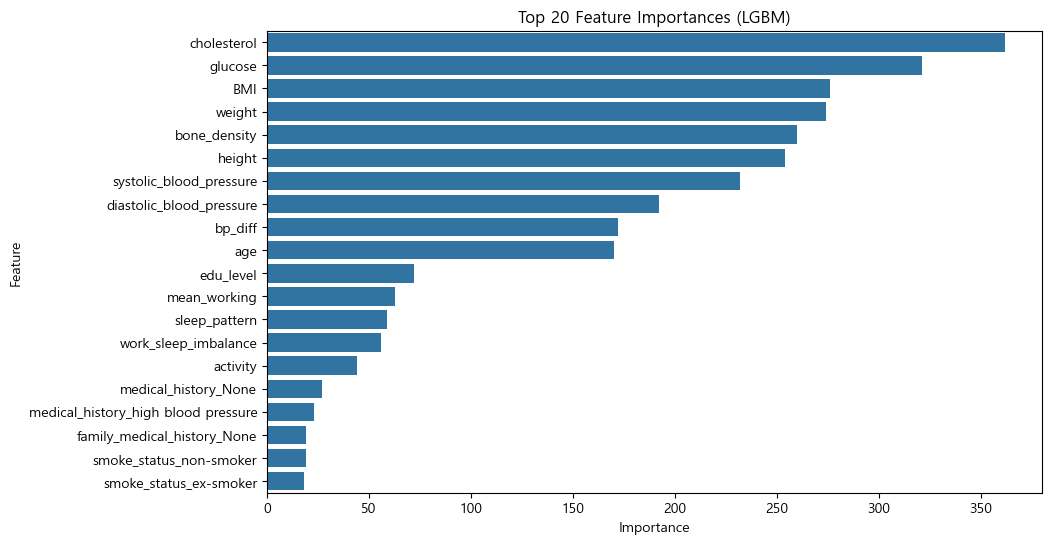

In [ ]:
importances = lgbm.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (LGBM)')
plt.show()

In [ ]:
submission = pd.read_csv('./sample_submission.csv')

In [ ]:
submission['stress_score'] = pred
submission.head()

ID  stress_score
0  TEST_0000      0.476419
1  TEST_0001      0.627898
2  TEST_0002      0.259774
3  TEST_0003      0.467328
4  TEST_0004      0.533462

In [ ]:
submission.to_csv('submit.csv', index=False)

In [ ]:
# train에서 나눠서 데이콘에서 측정하는 MAE와 다를수있음
# 성능이 올라갔는지 그대로인지 내려갔는지 경향만 파악할 수 있음
# 확인용으로만 쓸것

import datetime

# MAE 로그파일 세팅
def loging(MAE):
    with open('./mae_log', mode='a', encoding='utf-8') as f:
        current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"시간: {current_time} / MAE: {MAE}\n")

# MAE 체크용
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

X_train = train_set.drop(['ID', 'stress_score'], axis=1)
y_train = train_set['stress_score']

X_val = val_set.drop(['ID', 'stress_score'], axis=1) 
y_val = val_set['stress_score']

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

val_pred = lgbm.predict(X_val)

MAE = mean_absolute_error(y_val, val_pred)

print(f"모델의 검증 MAE 점수: {MAE}")
loging(MAE)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481912
모델의 검증 MAE 점수: 0.20224606918306098
